In [14]:
import pandas as pd
import networkx as nx
import ast
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [15]:
from torch_geometric.datasets import WebKB

dataset = WebKB(root='./data/GNNBenchmarkDataset', name='Cornell')

data = dataset[0]

print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature matrix shape: {data.x.shape}")
print(f"Number of classes: {data.y.unique().size(0)}")
print(f"First node's features: {data.x[0]}")


Number of nodes: 183
Number of edges: 298
Node feature matrix shape: torch.Size([183, 1703])
Number of classes: 5
First node's features: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [16]:
class CustomGraphDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        graph_data = self.dataset[idx]
        
        graph = {
            'edge_index': graph_data.edge_index,
            'num_nodes': graph_data.num_nodes,
            'node_feat': graph_data.x
        }
        
        label = graph_data.y
        return graph, label

    def __len__(self):
        return len(self.dataset)

custom_dataset = CustomGraphDataset(dataset)
graph, label = custom_dataset[0]

In [17]:
edge_index = data.edge_index
num_nodes = data.num_nodes 
G = nx.Graph()

G.add_nodes_from(range(num_nodes))

edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))  # Convert tensor to list of tuples
G.add_edges_from(edges)

In [18]:
results = pd.read_csv('subgroups_cornell.csv')
results.head()

,node,rho,sigma,q,ranks,reference,subgroup
0,78,22,4,0.242274,"[(78, True), (26, False), (143, True), (57, Tr...","[78, 26, 143, 57, 170, 119, 14, 59, 168, 18, 5...","[78, 26, 143, 57]"
1,60,24,4,0.238145,"[(60, True), (57, True), (119, False), (59, Tr...","[60, 57, 119, 59, 168, 18, 132, 174, 157, 131,...","[60, 57, 119, 59]"
2,76,36,4,0.231481,"[(76, True), (57, True), (60, True), (127, Tru...","[76, 57, 60, 127, 119, 168, 174, 59, 45, 14, 1...","[76, 57, 60, 127]"
3,135,36,11,0.228925,"[(135, True), (64, True), (5, False), (57, Tru...","[135, 64, 5, 57, 22, 110, 18, 103, 45, 92, 59,...","[135, 64, 5, 57, 22, 110, 18, 103, 45, 92, 59]"
4,165,36,5,0.225677,"[(165, False), (149, True), (67, True), (97, T...","[165, 149, 67, 97, 57, 174, 110, 119, 144, 157...","[165, 149, 67, 97, 57]"


In [19]:
index_78 = results[results['node'] == 78].index[0]
ranks_list = ast.literal_eval(results['ranks'][index_78])
ranks_list

[(78, True),
 (26, False),
 (143, True),
 (57, True),
 (170, False),
 (119, False),
 (14, False),
 (59, True),
 (168, False),
 (18, False),
 (55, False),
 (131, False),
 (157, False),
 (1, False),
 (163, False),
 (40, False),
 (98, False),
 (132, False),
 (174, False),
 (124, False),
 (178, False),
 (109, False),
 (45, True),
 (58, True),
 (177, True),
 (31, True),
 (107, False),
 (141, True),
 (128, False),
 (103, True),
 (112, False),
 (155, False),
 (110, False),
 (147, False),
 (164, False),
 (74, False),
 (15, False),
 (82, True),
 (144, False),
 (175, False),
 (77, True),
 (60, True),
 (127, True),
 (24, True),
 (53, True),
 (34, False),
 (176, False),
 (17, True),
 (61, False),
 (116, True),
 (165, False),
 (108, False),
 (96, True),
 (80, True),
 (154, False),
 (160, False),
 (42, True),
 (41, False),
 (11, False),
 (46, True),
 (16, True),
 (3, False),
 (50, False),
 (99, False),
 (100, False),
 (113, True),
 (88, False),
 (71, False),
 (43, False),
 (148, False),
 (72, True),

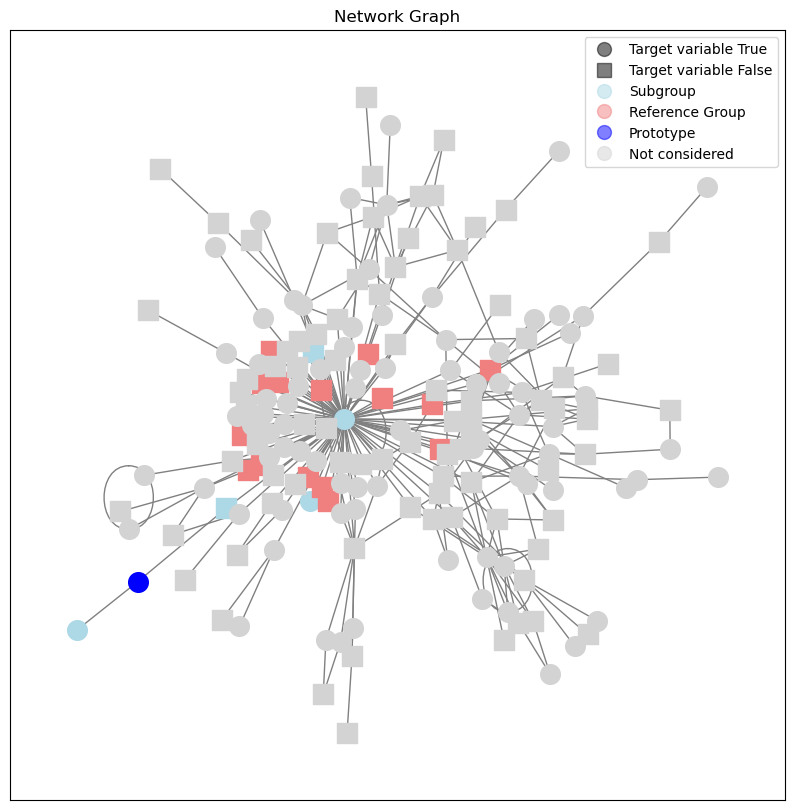

In [20]:
prototypes = [78]

reference_groups = {
    78: [78, 26, 143, 57, 170, 59, 119, 14, 168, 18, 55, 131, 157, 1, 163, 40, 98, 132, 174, 124, 178]
}
subgroups = {
    78: [78, 26, 143, 57, 170, 59]
}

def get_node_status(node, prototype):
    index_prototype = results[results['node'] == prototype].index[0]
    ranks_list = ast.literal_eval(results['ranks'][index_prototype])
    for rank_node, status in ranks_list:
        if rank_node == node:
            return status

prototype_nodes_true = []
prototype_nodes_false = []
subgroup_nodes_true = []
subgroup_nodes_false = []
reference_group_nodes_true = []
reference_group_nodes_false = []
therest_nodes = set(G.nodes())

for prototype in prototypes:
    prototype_nodes = [node for node in G.nodes() if node == prototype]
    prototype_nodes_true.extend([node for node in prototype_nodes if get_node_status(node, prototype)])
    prototype_nodes_false.extend([node for node in prototype_nodes if not get_node_status(node, prototype)])

    subgroup_nodes = [node for node in subgroups[prototype] if node != prototype]
    subgroup_nodes_true.extend([node for node in subgroup_nodes if get_node_status(node, prototype)])
    subgroup_nodes_false.extend([node for node in subgroup_nodes if not get_node_status(node, prototype)])

    reference_group_nodes = [node for node in reference_groups[prototype] if node not in subgroups[prototype] and node != prototype]
    reference_group_nodes_true.extend([node for node in reference_group_nodes if get_node_status(node, prototype)])
    reference_group_nodes_false.extend([node for node in reference_group_nodes if not get_node_status(node, prototype)])

    therest_nodes -= set(reference_groups[prototype])
    therest_nodes -= {prototype}

the_rest_group_nodes_true = [node for node in therest_nodes if get_node_status(node, prototype)]
the_rest_group_nodes_false = [node for node in therest_nodes if not get_node_status(node, prototype)]

plt.figure(figsize=(10, 10))
position = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos=position, edge_color='gray')

nx.draw_networkx_nodes(G, pos=position, nodelist=prototype_nodes_true, node_color='blue', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=prototype_nodes_false, node_color='blue', node_shape='s', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=subgroup_nodes_true, node_color='lightblue', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=subgroup_nodes_false, node_color='lightblue', node_shape='s', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=reference_group_nodes_true, node_color='lightcoral', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=reference_group_nodes_false, node_color='lightcoral', node_shape='s', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=the_rest_group_nodes_true, node_color='lightgray', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=the_rest_group_nodes_false, node_color='lightgray', node_shape='s', node_size=200)

plt.title("Network Graph")

circle_marker = Line2D([0], [0], marker='o', color='black', label='Target variable True', markersize=10, linestyle='None', markerfacecolor='black', alpha=0.5)
square_marker = Line2D([0], [0], marker='s', color='black', label='Target variable False', markersize=10, linestyle='None', markerfacecolor='black', alpha=0.5)

prototype_marker = Line2D([0], [0], marker='o', color='blue', label='Prototype', markersize=10, linestyle='None', markerfacecolor='blue', alpha=0.5)
subgroup_marker = Line2D([0], [0], marker='o', color='lightblue', label='Subgroup', markersize=10, linestyle='None', markerfacecolor='lightblue', alpha=0.5)
reference_marker = Line2D([0], [0], marker='o', color='lightcoral', label='Reference Group', markersize=10, linestyle='None', markerfacecolor='lightcoral', alpha=0.5)
therest_marker = Line2D([0], [0], marker='o', color='lightgray', label='Not considered', markersize=10, linestyle='None', markerfacecolor='lightgray', alpha=0.5)

plt.legend(handles=[circle_marker, square_marker, subgroup_marker, reference_marker, prototype_marker, therest_marker], loc='upper right')

plt.show()